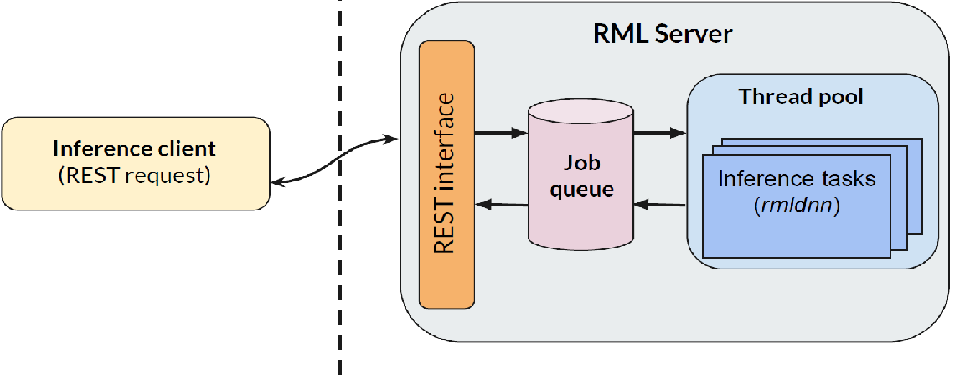

In [ ]:
import os
import numpy as np
import h5py as h5
import requests
import json
import matplotlib.pyplot as plt
from keras.models import model_from_json # Only for network visualization
from tensorflow.keras.utils import plot_model # Only for network visualization

## Helper functions

In [ ]:
# Generate application JSON configuration
def create_request(model, network, sample, batch_size=1):
    config = {
        "neural_network": {
            "checkpoints": {
                "load": model
            },
            "data": {
                "type": "numpy",
                "test_input_path" : sample,
                "test_target_path": sample,
                "test_batch_size": batch_size
            },
            "loss": {
                "function": "Poisson3d_PDE"
            },
            "layers": network
        }
    }
    
    return json.dumps(config)

In [ ]:
def display_slice(pred, truth):
    fig, ax = plt.subplots(1, 3, figsize=[16, 16])
    #fig.suptitle('Vertically stacked subplots')
    ax[0].set_title('DiffNet')
    im0 = ax[0].imshow(pred, origin='lower', cmap='jet')
    ax[1].set_title('FEM')
    im1 = ax[1].imshow(truth, origin='lower', cmap='jet')
    ax[2].set_title('Error')
    im2 = ax[2].imshow(pred - truth, origin='lower', cmap='jet')
    fig.colorbar(im0, ax = ax[0], shrink=0.3)
    fig.colorbar(im1, ax = ax[1], shrink=0.3)
    fig.colorbar(im2, ax = ax[2], shrink=0.3)
    plt.show()
    

### Configuration

In [ ]:
model   = '/home/ubuntu/models/model_checkpoint_64x64x64_ep50.pt'
network = '/home/ubuntu/networks/unet3d_64x64x64.json'
sample  = '/home/ubuntu/data/nu.npy'

In [ ]:
model_json = open('/home/ubuntu/networks/unet3d_64x64x64_keras.json', 'r').read()
keras_model = model_from_json(model_json)
plot_model(keras_model, show_shapes=True)

In [ ]:
plt.imshow(np.load(sample)[0, 32, :, :], origin='lower', cmap='jet')

### Solving 3D Poisson PDE using RML Server

In [ ]:
# Send request to PDE solver and examine response
response = requests.post('http://127.0.0.1:9080/run/dnn/60000', create_request(model, network, sample))
data = response.json()
data.keys()

In [ ]:
print(f"Status = {data['status']}\nExit code = {data['exit_code']}")
if (data['exit_code'] != 0):
    print(f"Reason = {data['output']}")

In [ ]:
# Get prediction(s)
print(f"Num predictions = {len(data['output']['tensors'])}")
output = data['output']['tensors'][0]
output.keys()

In [ ]:
output['dims']

In [ ]:
# Reshape prediciton values: the resulting tensor is the solution to the 3D Poisson PDE
pred = np.asarray(output['values']).reshape(output['dims']).squeeze()
pred.shape

### Visualizing DiffNet prediction and FEM solution

In [ ]:
fem_solution = np.load('/home/ubuntu/data/fem.npy')
x = 45
display_slice(pred[x, :, :], fem_solution[x, :, :])

### Shutdown RML Server

In [ ]:
response = requests.get('http://127.0.0.1:9080/stop')
response.json()